In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

#### Thinkful Guided Example Code

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)
# Note the warning about dtypes.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [4]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [5]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

#cross_val_score(rfc, X, Y, cv=10)

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

### PCA

In [6]:
# Your code here.
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

In [7]:
rfc = ensemble.RandomForestClassifier()
scores = cross_val_score(rfc, X_pca, Y, cv=10)
scores.mean()

0.9370929086763733

Average accuracy of 93.5% with only 20 features.  Keep reducing features to identify fewer key features.

In [8]:
pca2 = PCA(n_components=15)
X_pca2 = pca2.fit_transform(X)

In [9]:
rfc2 = ensemble.RandomForestClassifier()
scores2 = cross_val_score(rfc2, X_pca2, Y, cv=10)
scores2.mean()

0.932832569262232

Great! With only 15 features, accuracy remains above 90% in ten-fold cross validation!  I will continue to experiment to identify other ways of identifying key features.

__THIS IS THE BEST VERSION OF THE MODEL__



### Piecewise using T-test

In [10]:
#creating data frame with only continuous variables
df_cont = y2015.loc[:, ['int_rate', 'installment', 'annual_inc', 'dti', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                        'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 
                        'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'loan_status']]

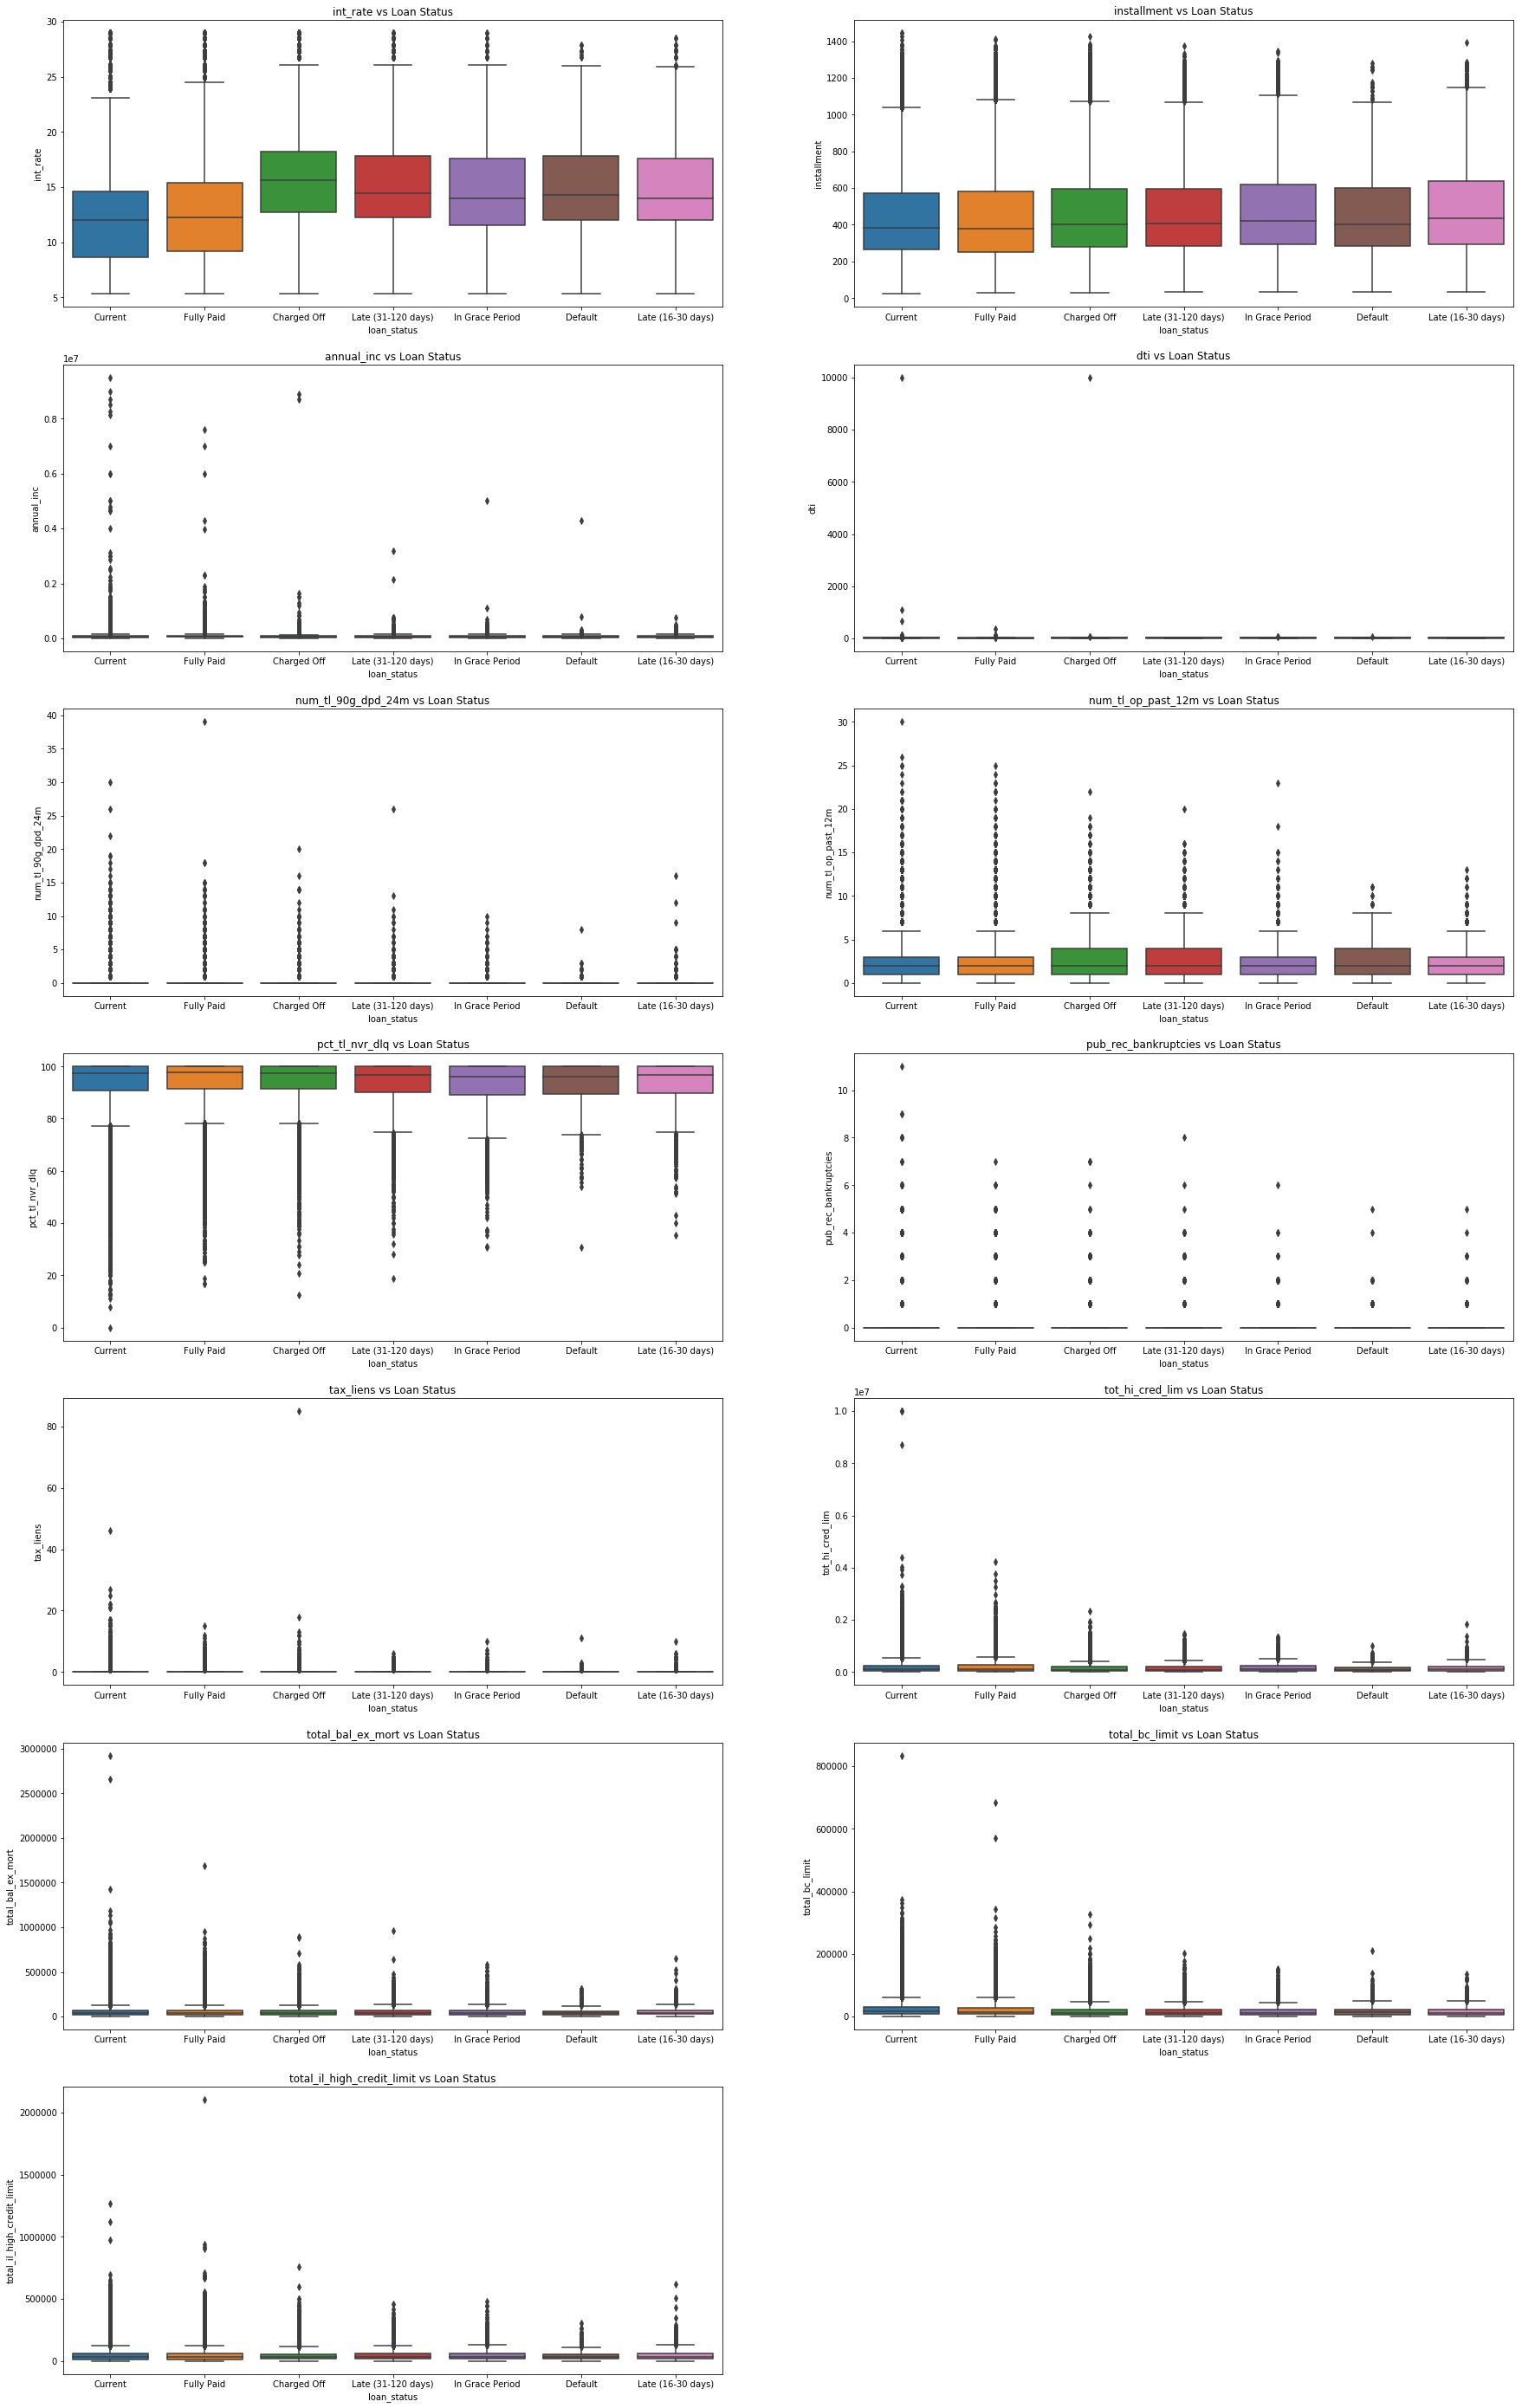

In [11]:
#plotting continuous variables versus loan status to determine correlations
plt.figure(figsize=(30,50))
i=0
for col in df_cont.drop('loan_status', 1):
    i+=1
    plt.subplot(7,2,i)
    sns.boxplot(x=y2015['loan_status'], y=col, data=df_cont)
    plt.title('{} vs Loan Status'.format(col))
    
plt.show()

It appears that there are a number of outliers that are skewing the data. Need to remove outliers in order to better fit data.

In [12]:
#removing outliers for each column

for col in df_cont.drop('loan_status', 1).columns:
    median = df_cont[col].median()
    std = df_cont[col].std()
    out_high = median + 2*std
    out_low = median - 2*std
    df_cont[col] = df_cont[col].map(lambda x: out_high if x > out_high else x)
    df_cont[col] = df_cont[col].map(lambda x: out_low if x < out_low else x)

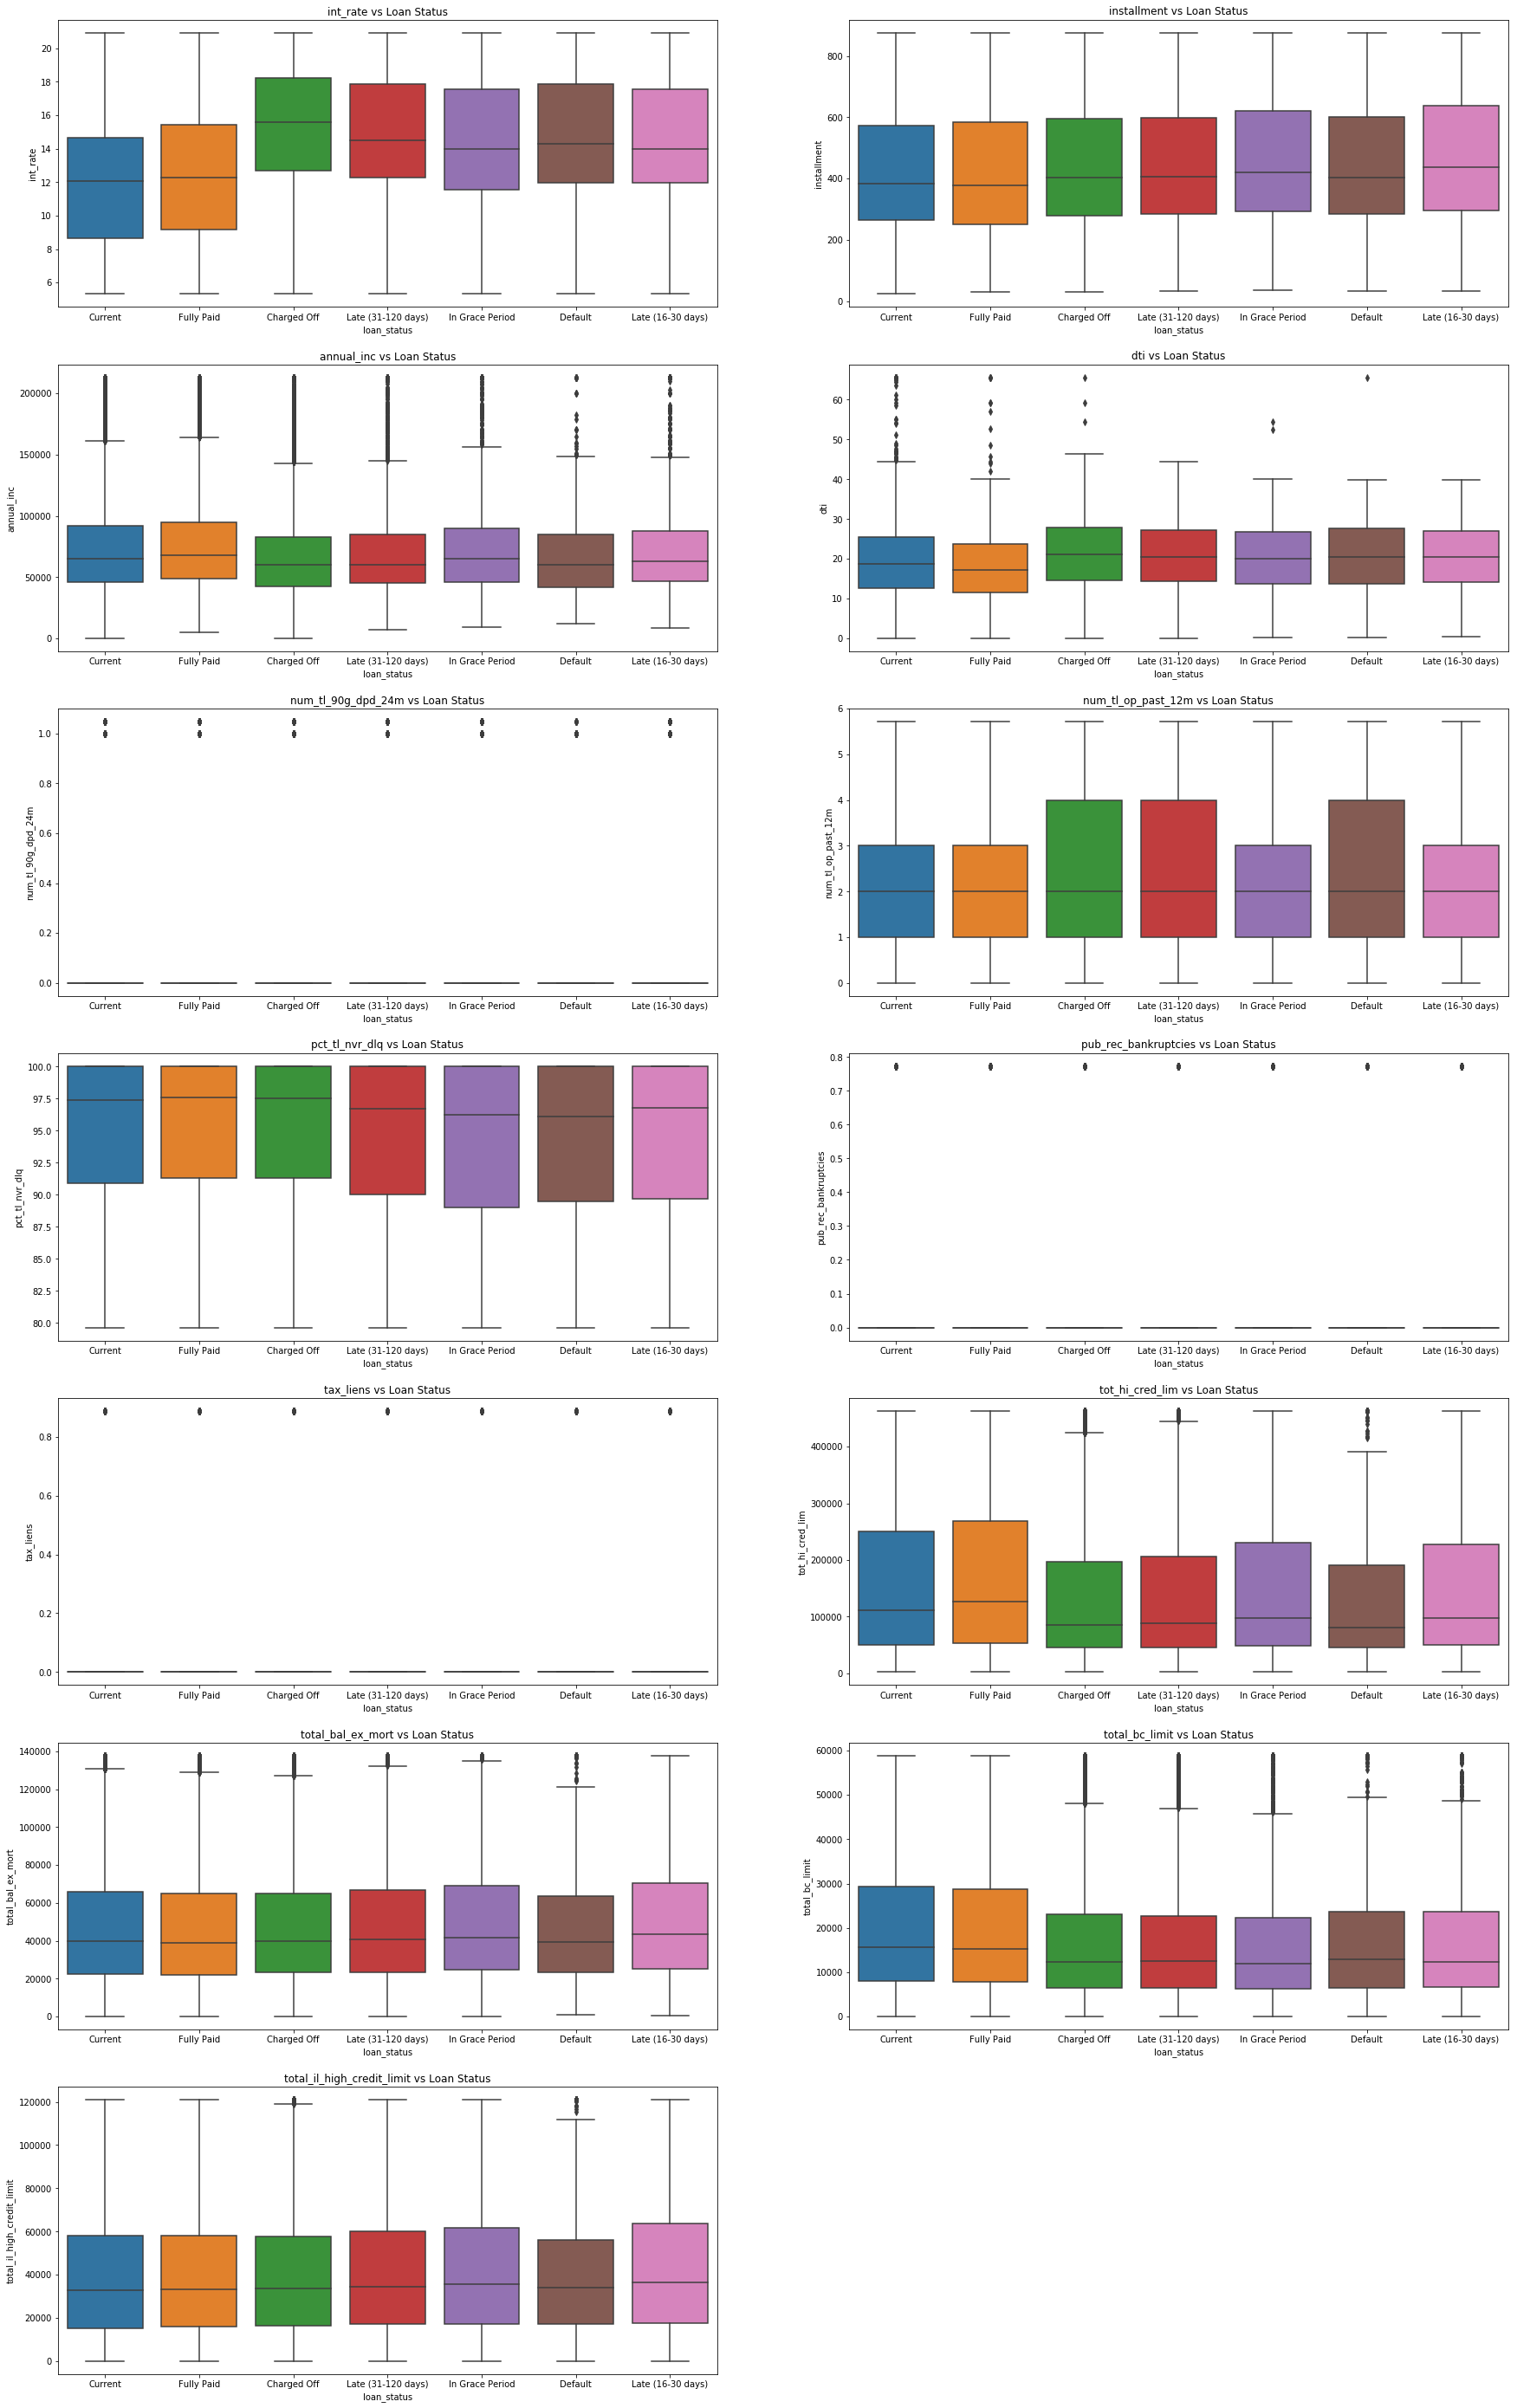

In [13]:
#re-plotting to determine correlations
plt.figure(figsize=(30,50))
i=0
for col in df_cont.drop('loan_status', 1):
    i+=1
    plt.subplot(7,2,i)
    sns.boxplot(x=y2015['loan_status'], y=col, data=df_cont)
    plt.title('{} vs Loan Status'.format(col))
    
plt.show()

Most of these are too close to determine significant differences between the variable and loan status.  Complete t-test to determine significance.

In [14]:
#running t-tests between default and current status of loan versus all continuous variables
for col in df_cont.columns:
    print('\n', col)
    print(ttest_ind(
        df_cont[df_cont['loan_status']=='Default'][col],
        df_cont[df_cont['loan_status']=='Current'][col]))


 int_rate
Ttest_indResult(statistic=18.51431942668891, pvalue=1.7535758330495608e-76)

 installment
Ttest_indResult(statistic=2.4494976601523812, pvalue=0.014306154756760623)

 annual_inc
Ttest_indResult(statistic=-4.8442063669760715, pvalue=1.271845844386043e-06)

 dti
Ttest_indResult(statistic=5.535721258185507, pvalue=3.102190135972783e-08)

 num_tl_90g_dpd_24m
Ttest_indResult(statistic=-0.08681129199428612, pvalue=0.9308215721064628)

 num_tl_op_past_12m
Ttest_indResult(statistic=11.494338525621949, pvalue=1.4303687219306825e-30)

 pct_tl_nvr_dlq
Ttest_indResult(statistic=-3.459352351448719, pvalue=0.0005415542909363985)

 pub_rec_bankruptcies
Ttest_indResult(statistic=4.4437557507108165, pvalue=8.843483976089118e-06)

 tax_liens
Ttest_indResult(statistic=0.752067848479735, pvalue=0.45201087190267497)

 tot_hi_cred_lim
Ttest_indResult(statistic=-6.247245148717844, pvalue=4.183354196561888e-10)

 total_bal_ex_mort
Ttest_indResult(statistic=-0.027558913142431554, pvalue=0.9780139708

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

The p-values that are significant under p-values of 0.05, will be used as features in our new Random Forest Classifier model. 

Constructing the features below

In [15]:
#assembling features of significance against same Y.
Y = y2015['loan_status']
X3 = pd.DataFrame(df_cont.loc[:, ['int_rate', 'num_tl_op_past_12m', 'tot_hi_cred_lim', 
                                  'total_bc_limit', 'pct_tl_nvr_dlq', 'dti', 'annual_inc']])
X3.head()

,int_rate,num_tl_op_past_12m,tot_hi_cred_lim,total_bc_limit,pct_tl_nvr_dlq,dti,annual_inc
0,14.85,2.000000,298100.0,58880.742224,79.649202,33.18,48000.0
1,7.49,2.000000,88635.0,12500.000000,100.000000,22.44,60000.0
2,7.49,0.000000,373572.0,38400.000000,100.000000,26.02,109000.0
3,6.49,0.000000,304003.0,41500.000000,91.700000,21.60,92000.0
4,19.89,5.707716,38998.0,2750.000000,100.000000,25.49,55000.0


In [16]:
#assembling model and running cross validation score
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X3, Y, cv=10)

array([0.65643181, 0.65018641, 0.65657429, 0.653226  , 0.65414391,
       0.65252909, 0.65161842, 0.64855494, 0.64694706, 0.60205196])

Accuracy of only about 65%

In [17]:
#inspecting one entry to identify categorical variables
y2015.iloc[0]

id                                            6.80094e+07
member_id                                     7.28681e+07
loan_amnt                                           16000
funded_amnt                                         16000
funded_amnt_inv                                     16000
term                                            60 months
int_rate                                            14.85
installment                                        379.39
grade                                                   C
emp_length                                      10+ years
home_ownership                                   MORTGAGE
annual_inc                                          48000
verification_status                          Not Verified
issue_d                                          Dec-2015
loan_status                                       Current
pymnt_plan                                              n
purpose                                       credit_card
title         

In [18]:
#utilizing categorical variables to analyze for relationship to loan status
df_cat = y2015.loc[:, ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 
                       'pymnt_plan', 'purpose', 'initial_list_status']]
df_cat.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,initial_list_status
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,n,credit_card,w
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,n,credit_card,w
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,w
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,w
4,36 months,E,8 years,RENT,Verified,Dec-2015,n,debt_consolidation,w


In [19]:
#Creating counttable for each variable and then performing chisquare test to determine significance
for col in df_cat.columns:
    counttable = pd.crosstab(y2015['loan_status'], df_cat[col])
    print('\n', col)
    print(chi2_contingency(counttable))


 term
(3564.65289127332, 0.0, 6, array([[ 19621.27736971,   9556.72263029],
       [193276.77750151,  94137.22249849],
       [   535.28469348,    260.71530652],
       [ 59169.80514373,  28819.19485627],
       [  2905.06265807,   1414.93734193],
       [  1269.61997649,    618.38002351],
       [  6395.172657  ,   3114.827343  ]]))

 grade
(20736.89894503785, 0.0, 36, array([[5.08150847e+03, 8.14901119e+03, 8.35418118e+03, 4.34134438e+03,
        2.42157410e+03, 6.80227564e+02, 1.50153115e+02],
       [5.00547219e+04, 8.02707486e+04, 8.22917483e+04, 4.27638342e+04,
        2.38533929e+04, 6.70049095e+03, 1.47906325e+03],
       [1.38627759e+02, 2.22311773e+02, 2.27908980e+02, 1.18435469e+02,
        6.60625465e+01, 1.85571712e+01, 4.09630131e+00],
       [1.53237661e+04, 2.45741088e+04, 2.51928182e+04, 1.30917318e+04,
        7.30248417e+03, 2.05129012e+03, 4.52800824e+02],
       [7.52351655e+02, 1.20651615e+03, 1.23689296e+03, 6.42765362e+02,
        3.58530403e+02, 1.00712286e+02

Most of the pvalues of the chi square tests are 0.0.  Is this another example of highly significant? Or why are they mostly all 0.0?

In [20]:
#assuming significance of all variables, turning into continuous by getting dummies and assigning features
X4 = df_cat
Y = y2015['loan_status']
X4 = pd.get_dummies(X4)

In [21]:
#running model with categorical dummies
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X4, Y, cv=5)

array([0.67302692, 0.26788174, 0.21865353, 0.23263435, 0.36341075])

Cross validation scores are low and all over the place.  I need to combine both categorical and continuous variables into same data frame to score.

### Trying SelectKBest feature selection function

In [22]:
from sklearn.feature_selection import SelectKBest

X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X_best = SelectKBest(score_func='chi2', k=10).fit_transform(X, Y)

ValueError: could not convert string to float: 'Not Verified'

I tried this feature selection function with a couple of different score functions.  Does this not work because the data frame is mixed with categorical and continuous variables?  Or do you have an example of this in practice? I couldn't really tell from the link you sent.